In [1]:
import numpy as np
import random
from scipy.linalg import toeplitz, matmul_toeplitz

import itertools
from itertools import product

import matplotlib.pyplot as plt

from tqdm import tqdm

import math

In [ ]:
class StrideTwoToeplitz:

  def __init__(self, first_two_cols, r):

    if type(first_two_cols) is not np.ndarray:
      first_two_cols = np.array(first_two_cols)

    if type(r) is not np.ndarray:
      r = np.array(r)

    if r[0] != first_two_cols[0,0]:
      raise ValueError("first element of r must be equal to first element of first_two_cols")
    if r[1] != first_two_cols[0,1]:
      raise ValueError("second element of r must be equal to second element of first_two_cols")

    self.first_two_cols = first_two_cols
    self.r = r
    self.rows = first_two_cols.shape[0]
    self.cols = r.size

  def get_entry(self, i, j):
      if j - 2 * i >= 0:
        return self.r[j - 2 * i]

      if j % 2 == 0:
        return self.first_two_cols[i - j//2, 0]

      return self.first_two_cols[i  - j//2, 1]

  def wrapped_submat(self, i, j, width, height):
    """
    submatrix with top-left corner at (i,j) and dimensions (at most) width x height.
    wraps around in the horizontal direction, but truncates vertically.

    This is only useful if the matrix happens to be circulant.
    """

    height = min(self.rows - 1 - i, height) #submatrix height

    sub_first_col = np.array([self.get_entry(i+k,j) for k in range(height)])
    sub_second_col = np.array([self.get_entry(i+k,j+1) for k in range(height)])
    sub_first_two_cols = np.vstack([sub_first_col, sub_second_col]).T

    sub_r = np.array([self.get_entry(i, (j+k) % self.cols) for k in range(width)])

    print(f"sub_first_two_cols: {sub_first_two_cols}")
    print(f"sub_r: {sub_r}")

    return StrideTwoToeplitz(sub_first_two_cols, sub_r)


  def __getitem__(self, x):
    if type(x) is tuple:
      return self.get_entry(x[0], x[1])
    else:
      raise ValueError("Invalid slice to StrideTwoToeplitz")

  def to_numpy(self):
    return np.array([[self.get_entry(i,j) for j in range(self.cols)] for i in range(self.rows)])

  def __str__(self):
    return self.to_numpy().__str__()


r = np.array([1,2,3,4,5,6,7,8])
first_two = np.array([[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16]])

A = StrideTwoToeplitz(first_two, r)
print(A)
B = A.wrapped_submat(1,6,4,4)
print(B)

[[ 1  2  3  4  5  6  7  8]
 [ 3  4  1  2  3  4  5  6]
 [ 5  6  3  4  1  2  3  4]
 [ 7  8  5  6  3  4  1  2]
 [ 9 10  7  8  5  6  3  4]
 [11 12  9 10  7  8  5  6]
 [13 14 11 12  9 10  7  8]
 [15 16 13 14 11 12  9 10]]
sub_first_two_cols: [[5 6]
 [3 4]
 [1 2]
 [3 4]]
sub_r: [5 6 3 4]
[[5 6 3 4]
 [3 4 5 6]
 [1 2 3 4]
 [3 4 1 2]]


In [ ]:
print(B.first_two_cols)
print(B.r)
print(B.to_numpy())

[[5 6]
 [3 4]
 [1 2]
 [3 4]]
[5 6 3 4]
[[5 6 3 4]
 [3 4 5 6]
 [1 2 3 4]
 [3 4 1 2]]


In [ ]:
B.get_entry(0,2)

3

In [ ]:
def _flip_op(x):
  fst = np.array([x[0]])
  sec = np.flip(x[1:])
  return np.concatenate([fst, sec])

def matmul_circulant(r, x):
  c = _flip_op(r)
  return matmul_toeplitz((c,r), x)

def circulant_convolution(x,y):
  return _flip_op(matmul_circulant(x, _flip_op(y)))

def matmul_stride_two_toeplitz(first_two_cols, r, x):
  c = np.flip(first_two_cols,axis=1).flatten()[1:]
  return matmul_toeplitz((c,r), x)[0::2]


def stride_two_toeplitz_entry(first_two_cols, r, i,j):
  if j - 2 * i >= 0:
    return r[j - 2 * i]

  if j % 2 == 0:
    return first_two_cols[i - j//2, 0]

  return first_two_cols[i  - j//2, 1]

def matmul_stride_two_toeplitz_half(first_two_cols, r, x):

  N = x.size

  assert r.size == N, "size mismatch"
  assert first_two_cols.shape == (N,2), "shape mismatch"

  #For small matrices, just do the multiplication
  if N <= 3:
    mat = np.zeros((N,N))
    for i in range(N):
      for j in range(N):
        if j >= i:
          mat[i,j] = stride_two_toeplitz_entry(first_two_cols, r, i, j)
    return mat @ x

  #Otherwise split up recursively

  mid = N//2

  x_1= x[:N//2]  #TL
  x_2 = x[(N+1)//2:] #BR
  x_3 = x[N//2 :] #TR

  #column mid and the following column
  mid_col = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, mid) for i in range(N)], (N,1))
  after_mid = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, mid+1) for i in range(N)], (N,1))
  two_after_mid = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, mid+2) for i in range(N)], (N,1))

  mid_and_next = np.hstack([mid_col, after_mid])
  mid_and_next_2 = np.hstack([after_mid, two_after_mid]) if N % 2 == 1 else mid_and_next #This could likely be cleaned up


  #print(f"mid_and_next: {mid_and_next}")

  TL_params = (first_two_cols[:N//2, :], r[:mid])
  TR_params = (mid_and_next[:(N+1)//2, :], r[mid:])

  BR_r = np.array([stride_two_toeplitz_entry(first_two_cols, r, (N+1)//2, j) for j in range((N+1)//2, N)])
  BR_params = (mid_and_next_2[(N+1)//2 :, :], BR_r)


  TR_prod = matmul_stride_two_toeplitz(*TR_params, x_3)
  TL_prod = matmul_stride_two_toeplitz_half(*TL_params, x_1)
  BR_prod = matmul_stride_two_toeplitz_half(*BR_params, x_2)

  if N % 2 == 1:
    TL_prod = np.hstack([TL_prod, np.array([0])])

  return np.hstack([TL_prod + TR_prod, BR_prod])

"""
def stride_two_toeplitz_transpose(first_two_cols, r):
  M = first_two_cols.shape[0]
  N = r.size

  new_r = first_two_cols[:,0].reshape(M)

  #print(new_r)

  col1 = np.reshape(r, (N,1))
  col2 = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, 1,j) for j in range(N)], (N,1))

  #print(col1)
  #print(col2)

  new_first_two = np.hstack([col1, col2])

  return new_first_two, new_r
"""

def matmul_stride_two_toeplitz_BL(first_two_cols, r, x):
  N = x.size
  left1 = np.array([stride_two_toeplitz_entry(first_two_cols, r, i, N-2) for i in range(N-1,-1,-1)])
  left2 = np.array([stride_two_toeplitz_entry(first_two_cols, r, i, N-1) for i in range(N-1,-1,-1)])
  two_cols_prime = np.vstack([left2, left1]).T

  r_prime = np.array([stride_two_toeplitz_entry(first_two_cols, r, N-1, i) for i in range(N-1,-1,-1)])

  #print(f"two_cols_prime: {two_cols_prime}")
  #print(f"r_prime: {r_prime}")

  return np.flip(matmul_stride_two_toeplitz_half(two_cols_prime, r_prime, np.flip(x)))

def matmul_parallelogram(first_two_cols, r, x):
  N = r.size
  M = first_two_cols.shape[0]

  assert M <= N, "M must be <= N"

  #print("here")
  x1 = x[:M-1]
  x2 = x[M-1: N-M+1]
  x3 = x[N-M+1:]

  #print(f"x1:{x1}")
  #print(f"x2:{x2}")
  #print(f"x3:{x3}")

  r1 = r[:M-1]
  r2 = r[M-1: N-M+1]
  r3 = r[N-M-1:N-2]

  #print(f"  r1:{r1}")
  #print(f"  r2:{r2}")
  #print(f"  r3:{r3}")

  two_cols1 = first_two_cols[:M-1, :]

  #print(f"two_cols1:{two_cols1}")

  mid1 = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, M-1) for i in range(M)], (M,1))
  mid2 = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, M) for i in range(M)], (M,1))
  two_cols2 = np.hstack([mid1, mid2])
  #print(f"two_cols2:{two_cols2}")

  end1 = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, N-M+1) for i in range(M)], (M,1))
  end2 = np.reshape([stride_two_toeplitz_entry(first_two_cols, r, i, N-M+2) for i in range(M)], (M,1))
  two_cols3 = np.hstack([end1, end2])[1:, :]
  #print(f"two_cols3:{two_cols3}")

  prod1 = matmul_stride_two_toeplitz_half(two_cols1, r1, x1)
  prod1 = np.hstack([prod1, np.array([0])])

  prod2 = matmul_stride_two_toeplitz(two_cols2, r2, x2)[:M]
  prod3 = matmul_stride_two_toeplitz_BL(two_cols3, r3, x3)
  prod3 = np.hstack([np.array([0]), prod3])

  #print(f"prod1:{prod1}")
  #print(f"prod2:{prod2}")
  #print(f"prod3:{prod3}")

  return prod1 + prod2 + prod3

def matmul_toeplitz_stripe(first_two_cols, r, width, x):
  N = x.size
  assert first_two_cols.shape == (N,2), "shape mismatch"
  assert r.size == N, "size mismatch"

  prod = np.zeros(N)
  for i in range(0, N, width):
    sub_first_two, sub_r = submat_params(first_two_cols, r, i, width, 2*width-1)
    h = sub_first_two.shape[0]

    print(f"sub_first_two:{sub_first_two}")
    print(f"sub_r:{sub_r}")

    x_indices = [k % N for k in range(i, i+width+h-1)]
    prod_indices = [k % N for k in range(i, i+h)]

    sub_x = x[x_indices]

    print(f"sub_x:{sub_x}")

    parallelogram_prod = matmul_parallelogram(sub_first_two, sub_r, sub_x)
    print(f"parallelogram_prod:{parallelogram_prod}")

    prod[prod_indices] += parallelogram_prod

  return prod

**Tests**

*Stripe*

In [ ]:
r = np.array([1,2,3,4,5,6,7,8])
x = np.array([10,20,30,40,50,60,70,80])
first_two = np.array([[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16]])
w = 3

M = first_two.shape[0]
N = x.size

A = np.zeros((M,N))
for i in range(M):
  for j in range(N):
    #print(f"i:{i}, j:{j}")
    if (j >= i and j < i + w) or (i+w >= N and j <= i+w-(N+1)):
      A[i,j] = stride_two_toeplitz_entry(first_two, r, i, j)

print(A)

print(A @ x)
print(matmul_toeplitz_stripe(first_two, r, w, x))

[[ 1.  2.  3.  0.  0.  0.  0.  0.]
 [ 0.  4.  1.  2.  0.  0.  0.  0.]
 [ 0.  0.  3.  4.  1.  0.  0.  0.]
 [ 0.  0.  0.  6.  3.  4.  0.  0.]
 [ 0.  0.  0.  0.  5.  6.  3.  0.]
 [ 0.  0.  0.  0.  0.  8.  5.  6.]
 [13.  0.  0.  0.  0.  0.  7.  8.]
 [15. 16.  0.  0.  0.  0.  0. 10.]]
[ 140.  190.  300.  630.  820. 1310. 1260. 1270.]


NameError: name 'submat_params' is not defined

*Parallelogram*

In [ ]:
r = np.array([1,2,3,4,5])
x = np.array([10,20,30,40,50])
first_two = np.array([[1,2],[3,4],[5,6]])

M = first_two.shape[0]
N = x.size

A = np.zeros((M,N))
for i in range(M):
  for j in range(N):
    #print(f"i:{i}, j:{j}")
    if j >= i and j - i <= N-M:
      A[i,j] = stride_two_toeplitz_entry(first_two, r, i, j)


if np.allclose(matmul_parallelogram(first_two, r, x), A@x):
  print("SUCCESS")
else:
  print("ERROR")

SUCCESS


*Tests for top part of Toeplitz*

In [ ]:
def stride_two_toeplitz_test_BL(first_two_cols, r, x):

  N = r.size
  A = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if j <= i:
        A[i,j] = stride_two_toeplitz_entry(first_two, r, i, j)

  check_ans = A @ x
  alg_ans = matmul_stride_two_toeplitz_BL(first_two, r, x)

  #print(check_ans)
  #print(alg_ans)

  if np.allclose(check_ans, alg_ans):
    print("SUCCESS")
  else:
    print("ERROR")

#test 1
first_two = np.array([[1,2],[30,40],[50,60],[70,80],[90,100]])
r = np.array([1,2,3,4,5])
x = np.array([1,10,100,1000,10000])
stride_two_toeplitz_test_BL(first_two, r, x)

#test2
first_two = np.array([[1,2],[30,40],[50,60],[70,80],[90,100],[110,120]])
r = np.array([1,2,3,4,5,6])
x = np.array([1,10,100,1000,10000,100000])
stride_two_toeplitz_test_BL(first_two, r, x)

#test 3
N = 200
first_two = np.random.randn(N,2)
r = np.random.randn(N)
r[0] = first_two[0,0]
r[1] = first_two[0,1]
x = np.random.randn(N)
stride_two_toeplitz_test_BL(first_two, r, x)

SUCCESS
SUCCESS
SUCCESS


In [ ]:
#r = np.array([1,2,3,4])
#first_two = np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])

#new_first_two, new_r = stride_two_toeplitz_transpose(first_two, r)
#print(new_first_two)
#print(new_r)

In [ ]:
def stride_two_toeplitz_test(first_two_cols, r, x):

  N = r.size
  A = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if j >= i:
        A[i,j] = stride_two_toeplitz_entry(first_two, r, i, j)

  check_ans = A @ x
  alg_ans = matmul_stride_two_toeplitz_half(first_two, r, x)

  #print(check_ans)
  #print(alg_ans)

  if np.allclose(check_ans, alg_ans):
    print("SUCCESS")
  else:
    print("ERROR")

In [ ]:
#test 1
first_two = np.array([[1,2],[30,40],[50,60],[70,80],[90,100]])
r = np.array([1,2,3,4,5])
x = np.array([1,10,100,1000,10000])
stride_two_toeplitz_test(first_two, r, x)

#test2
first_two = np.array([[1,2],[30,40],[50,60],[70,80],[90,100],[110,120]])
r = np.array([1,2,3,4,5,6])
x = np.array([1,10,100,1000,10000,100000])
stride_two_toeplitz_test(first_two, r, x)

#test 3
N = 200
first_two = np.random.randn(N,2)
r = np.random.randn(N)
r[0] = first_two[0,0]
r[1] = first_two[0,1]
x = np.random.randn(N)
stride_two_toeplitz_test(first_two, r, x)

SUCCESS
SUCCESS
SUCCESS


*Fast summation tests*

In [ ]:
def B_sum_fast(x, y, z, T):
  '''sum over (i,j,k) of x_i * y_j * z_k where i + j + k (mod N) [0,T-1]'''

  three_way_conv = circulant_convolution(circulant_convolution(x,y), z)
  return np.sum(three_way_conv[0:T])

def B_sum_naive(x, y, z, T):
    N = x.size
    triples = itertools.product(range(N), range(N), range(N))
    return sum([x[i]*y[j]*z[k] for i,j,k in triples if 0 <= (i + j + k) % N <= T-1])


def C_sum_components(x, y, T):
    '''
    vector whose index k entry is given by:
    sum over x_i y_j where i + j = k and 0 <= i-j <= T-1
    '''
    pass

def C_sum_naive(x, y, z, T):
    N = x.size
    triples = itertools.product(range(N), range(N), range(N))
    return sum([x[i]*y[j]*z[k] for i,j,k in triples
                if (i+j+k % N == 0) and 0 <= (j-i+N)%N <= T-1 ])


In [ ]:
x = np.random.randn(100)
y = np.random.randn(100)
z = np.random.randn(100)

fast = B_sum_fast(x,y,z,2)
print(f"fast:{fast}")

naive = B_sum_naive(x,y,z,2)
print(f"naive:{naive}")

print()

fast:57.151481072530714
naive:57.1514810725306



In [ ]:
"""
Check that stride two toeplitz works
"""

first_two = np.array([[1,2],[5,6],[7,8],[9,10],[11,12]])
r = np.array([1,2,3,4,5])

A = np.zeros((5,5))
for i in range(5):
  for j in range(5):
    A[i,j] = stride_two_toeplitz_entry(first_two, r, i, j)

x = np.array([1,10,100,1000,10000])

print("These should be equal:")
print(matmul_stride_two_toeplitz(first_two, r, x))
print(A @ x)

These should be equal:
[54321. 32165. 16587. 58809. 81031.]
[54321. 32165. 16587. 58809. 81031.]


**Ell_0 Sampling Tests**

In [2]:
def cube_value_check(X):
    if len(X.shape) != 3:
      raise ValueError("X must be a 3D array")

    N = X.shape[0]

    if X.shape[1] != N or X.shape[2] != N:
      raise ValueError("X must be a cube")

def random_permute(X):
  cube_value_check(X)
  N = X.shape[0]
  ind1 = list(range(N))
  ind2 = list(range(N))
  ind3 =  list(range(N))
  random.shuffle(ind1)
  random.shuffle(ind2)
  random.shuffle(ind3)
  indices = [ind1, ind2, ind3]
  return X[indices]

def B_sample(X,T):
  N = X.shape[0]
  prod_tuples = itertools.product(range(N), repeat=3)
  return [(i,j,k) for i,j,k in prod_tuples if 0 <= (i+j+k)%N <= T-1]

def C_sample(X,T):
    N = X.shape[0]
    return [(i,j, (i+j) % N) for i,j in itertools.product(range(N), range(N))
      if 0 <= (i-j)%N <= T-1]

def random_sample(X,samples):
  N = X.shape[0]
  prod_tuples = list(itertools.product(range(N),repeat=3))
  return random.sample(prod_tuples, samples)

def p_sample(X, p):

  cube_value_check(X)
  N = X.shape[0]

  if p >= 1/N:
    sample = B_sample(X, int(p * N) ) #We want T/N = p
  elif p >= 1/(N**2):
    sample = C_sample(X, int(p * (N**2)) ) #We want T/N^2 = p
  else:
    sample = random_sample(X, int(p * (N**3)))

  perm1 = list(range(N))
  perm2 = list(range(N))
  perm3 = list(range(N))
  random.shuffle(perm1)
  random.shuffle(perm2)
  random.shuffle(perm3)

  permuted_sample = [(perm1[i], perm2[j], perm3[k]) for i,j,k in sample]
  return permuted_sample


def random_sum(X, samples):
  #take a random sample of the entries of X and add them
  cube_value_check(X)
  N = X.shape[0]

  prod_tuples = list(itertools.product(range(N),repeat=3))
  indices = random.sample(prod_tuples, samples)
  return sum([X[i,j,k] for i,j,k in indices])

def p_sum_dense(X, p):
  """
  Compute the sum over a p-sample
  """
  N = X.shape[0]

  if p >= 1/N:
    return B_sum_dense(X, int(p * N) ) #We want T/N = p
  elif p >= 1/(N**2):
    return C_sum_dense(X, int(p * (N**2)) ) #We want T/N^2 = p
  else:
    return random_sum(X, int(p * (N**3)))


def is_singleton(X, sample):
  '''currently cheating'''
  return sum([X[i,j,k] != 0 for i,j,k in sample]) == 1

def ell_0_sample(X, buckets_per_level, level_gap):

  N = X.shape[0]
  p = 1/N**3

  #levels = []
  while(p < 1):
    #new_level = []

    for _ in range(buckets_per_level):
      sample = p_sample(X, p)
      sample_sum = sum(X[i,j,k] for i,j,k in sample)
      if sample_sum != 0 and is_singleton(X,sample):
          return sample_sum, p
      #new_level.append(sample_sum)

    #levels.append(new_level)
    p *= level_gap

  return None, None

def ell_0_experiment(N, support_mask, trials, buckets_per_level, level_gap):

  A = np.zeros((N,N,N))
  for idx,(i,j,k) in enumerate(support_mask):
    A[i,j,k] = idx+1

  supp_size = len(support_mask)
  hist = [0] * (supp_size+1)
  fail_count = 0
  for _ in tqdm(range(trials)):
    sample, p = ell_0_sample(A, buckets_per_level, level_gap)
    #print(f"p:{p}")
    if sample is not None:
      hist[int(sample)] += 1
    else:
      fail_count += 1

  return hist[1:], fail_count


def multi_region_experiment(N, regions, trials, buckets_per_level, level_gap):
  A = np.zeros((N,N,N))
  for idx, region in enumerate(regions):
    for i,j,k in region:
      A[i,j,k] = idx+1

  hist = [0]*(len(regions)+1)

  fail_count = 0
  for _ in tqdm(range(trials)):
    sample, p = ell_0_sample(A, buckets_per_level, level_gap)
    if sample is not None:
      hist[int(sample)] += 1
    else:
      fail_count += 1

  return hist[1:], fail_count

In [22]:
"""
Two disjoint rectangles that don't overlap in any of the three dimensions
"""
N = 40
trials = 1000
buckets_per_level = 10
level_gap = 5

h_params = [(1,1,1), (10,10,10), (20,20,20)]
k_params = [(1,1,20), (1,10,20), (1,20,20),(20,20,20)]

results = {}

for h, k in itertools.product(h_params, k_params):
    
    k1,k2,k3 = k
    h1,h2,h3 = h
    
    print(f"starting experiment: {h, k}")

    assert h1+k1 <= N and h2+k2 <= N and h3+k3 <= N

    region1 = list(itertools.product(range(k1), range(k2), range(k3)))

    rect2 = list(itertools.product(range(h1), range(h2), range(h3)))
    region2 = [(k1+x,k2+y, k3+z) for x,y,z in rect2]

    results[((k1,k2,k3), (h1,h2,h3))] = multi_region_experiment(N, 
                        [region1, region2], trials=trials, buckets_per_level = buckets_per_level, level_gap = level_gap)

    print(results)

starting experiment: ((1, 1, 1), (1, 1, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:03<00:00,  5.46it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0)}
starting experiment: ((1, 1, 1), (1, 10, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.70it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0)}
starting experiment: ((1, 1, 1), (1, 20, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1)}
starting experiment: ((1, 1, 1), (20, 20, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.52it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1)}
starting experiment: ((10, 10, 10), (1, 1, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.94it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0)}
starting experiment: ((10, 10, 10), (1, 10, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.45it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0)}
starting experiment: ((10, 10, 10), (1, 20, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.88it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0), ((10, 10, 10), (1, 20, 20)): ([297, 703], 0)}
starting experiment: ((10, 10, 10), (20, 20, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.69it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0), ((10, 10, 10), (1, 20, 20)): ([297, 703], 0), ((10, 10, 10), (20, 20, 20)): ([895, 104], 1)}
starting experiment: ((20, 20, 20), (1, 1, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.21it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0), ((10, 10, 10), (1, 20, 20)): ([297, 703], 0), ((10, 10, 10), (20, 20, 20)): ([895, 104], 1), ((20, 20, 20), (1, 1, 20)): ([1, 996], 3)}
starting experiment: ((20, 20, 20), (1, 10, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.85it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0), ((10, 10, 10), (1, 20, 20)): ([297, 703], 0), ((10, 10, 10), (20, 20, 20)): ([895, 104], 1), ((20, 20, 20), (1, 1, 20)): ([1, 996], 3), ((20, 20, 20), (1, 10, 20)): ([16, 982], 2)}
starting experiment: ((20, 20, 20), (1, 20, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.71it/s]


{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0), ((10, 10, 10), (1, 20, 20)): ([297, 703], 0), ((10, 10, 10), (20, 20, 20)): ([895, 104], 1), ((20, 20, 20), (1, 1, 20)): ([1, 996], 3), ((20, 20, 20), (1, 10, 20)): ([16, 982], 2), ((20, 20, 20), (1, 20, 20)): ([50, 950], 0)}
starting experiment: ((20, 20, 20), (20, 20, 20))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.65it/s]

{((1, 1, 1), (1, 1, 20)): ([965, 35], 0), ((1, 1, 1), (1, 10, 20)): ([997, 3], 0), ((1, 1, 1), (1, 20, 20)): ([997, 2], 1), ((1, 1, 1), (20, 20, 20)): ([999, 0], 1), ((10, 10, 10), (1, 1, 20)): ([20, 980], 0), ((10, 10, 10), (1, 10, 20)): ([161, 839], 0), ((10, 10, 10), (1, 20, 20)): ([297, 703], 0), ((10, 10, 10), (20, 20, 20)): ([895, 104], 1), ((20, 20, 20), (1, 1, 20)): ([1, 996], 3), ((20, 20, 20), (1, 10, 20)): ([16, 982], 2), ((20, 20, 20), (1, 20, 20)): ([50, 950], 0), ((20, 20, 20), (20, 20, 20)): ([513, 487], 0)}


In [23]:
results

{((1, 1, 1), (1, 1, 20)): ([965, 35], 0),
 ((1, 1, 1), (1, 10, 20)): ([997, 3], 0),
 ((1, 1, 1), (1, 20, 20)): ([997, 2], 1),
 ((1, 1, 1), (20, 20, 20)): ([999, 0], 1),
 ((10, 10, 10), (1, 1, 20)): ([20, 980], 0),
 ((10, 10, 10), (1, 10, 20)): ([161, 839], 0),
 ((10, 10, 10), (1, 20, 20)): ([297, 703], 0),
 ((10, 10, 10), (20, 20, 20)): ([895, 104], 1),
 ((20, 20, 20), (1, 1, 20)): ([1, 996], 3),
 ((20, 20, 20), (1, 10, 20)): ([16, 982], 2),
 ((20, 20, 20), (1, 20, 20)): ([50, 950], 0),
 ((20, 20, 20), (20, 20, 20)): ([513, 487], 0)}

In [11]:
"""
A rectangle and an equal amount of random noise
"""

results = {(1, 1, 1): ([468, 527], 5),
 (1, 1, 3): ([508, 492], 0),
 (1, 1, 9): ([522, 476], 2),
 (1, 1, 27): ([524, 476], 0),
 (1, 3, 1): ([519, 480], 1),
 (1, 3, 3): ([507, 489], 4),
 (1, 3, 9): ([499, 501], 0),
 (1, 9, 1): ([512, 485], 3),
 (1, 9, 3): ([509, 491], 0),
 (1, 9, 9): ([502, 498], 0),
 (3, 1, 1): ([489, 510], 1),
 (3, 1, 3): ([496, 503], 1),
 (3, 1, 9): ([523, 477], 0),
 (3, 3, 1): ([494, 506], 0),
 (3, 3, 3): ([527, 473], 0),
 (3, 3, 9): ([508, 492], 0),
 (3, 9, 1): ([512, 488], 0),
 (3, 9, 3): ([495, 505], 0),
 (3, 9, 9): ([506, 494], 0),
 (9, 1, 1): ([529, 470], 1),
 (9, 1, 3): ([497, 503], 0),
 (9, 1, 9): ([507, 493], 0),
 (9, 3, 1): ([507, 493], 0),
 (9, 3, 3): ([493, 507], 0),
 (9, 3, 9): ([532, 468], 0),
 (9, 9, 1): ([537, 463], 0),
 (9, 9, 3): ([504, 495], 1),
 (9, 9, 9): ([522, 477], 1)}

N = 40
trials = 1000
buckets_per_level = 10
level_gap = 5

dyadic_base = 3

logN = math.floor(math.log(N,dyadic_base))
rect_params = [(dyadic_base**i,dyadic_base**j,dyadic_base**k)
  for i,j,k in itertools.product(range(logN + 1), repeat=3)
  if dyadic_base**(i+j+k) <= (N**3)/2]

#results = {}
for k1, k2, k3 in rect_params:

  print(f"Running experiment for k1:{k1}, k2:{k2}, k3:{k3}")
  if (k1,k2,k3) in results.keys(): #This is just to allow reruns in case of failure
    continue

  support_mask = list(itertools.product(range(k1), range(k2), range(k3)))
  supp_size = k1*k2*k3

  rect_mask = list(itertools.product(range(k1), range(k2), range(k3)))

  remaining_coords = [(i,j,k) for i,j,k in itertools.product(range(N), repeat=3) if (i,j,k) not in support_mask]
  sampled_coords = random.sample(remaining_coords, supp_size)

  results[(k1,k2,k3)] = multi_region_experiment(N, [rect_mask, sampled_coords], trials, buckets_per_level, level_gap)

  print(results)

Running experiment for k1:1, k2:1, k3:1
Running experiment for k1:1, k2:1, k3:3
Running experiment for k1:1, k2:1, k3:9
Running experiment for k1:1, k2:1, k3:27
Running experiment for k1:1, k2:3, k3:1
Running experiment for k1:1, k2:3, k3:3
Running experiment for k1:1, k2:3, k3:9
Running experiment for k1:1, k2:3, k3:27


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:45<00:00,  6.06it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1)}
Running experiment for k1:1, k2:9, k3:1
Running experiment for k1:1, k2:9, k3:3
Running experiment for k1:1, k2:9, k3:9
Running experiment for k1:1, k2:9, k3:27


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.92it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0)}
Running experiment for k1:1, k2:27, k3:1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:55<00:00,  5.71it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0)}
Running experiment for k1:1, k2:27, k3:3


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.39it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0)}
Running experiment for k1:1, k2:27, k3:9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.03it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0)}
Running experiment for k1:1, k2:27, k3:27


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.31it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0)}
Running experiment for k1:3, k2:1, k3:1

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.06it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1)}
Running ex

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.77it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.84it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:55<00:00,  5.70it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.68it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.97it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.59it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.05it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.71it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.16it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:10<00:00,  7.64it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.94it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.78it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.87it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:56<00:00,  5.66it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:37<00:00,  6.36it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.97it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 10.99it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.40it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.77it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.83it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.77it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.90it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.13it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.58it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.12it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.09it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 16.96it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.88it/s]


{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.45it/s]

{(1, 1, 1): ([468, 527], 5), (1, 1, 3): ([508, 492], 0), (1, 1, 9): ([522, 476], 2), (1, 1, 27): ([524, 476], 0), (1, 3, 1): ([519, 480], 1), (1, 3, 3): ([507, 489], 4), (1, 3, 9): ([499, 501], 0), (1, 9, 1): ([512, 485], 3), (1, 9, 3): ([509, 491], 0), (1, 9, 9): ([502, 498], 0), (3, 1, 1): ([489, 510], 1), (3, 1, 3): ([496, 503], 1), (3, 1, 9): ([523, 477], 0), (3, 3, 1): ([494, 506], 0), (3, 3, 3): ([527, 473], 0), (3, 3, 9): ([508, 492], 0), (3, 9, 1): ([512, 488], 0), (3, 9, 3): ([495, 505], 0), (3, 9, 9): ([506, 494], 0), (9, 1, 1): ([529, 470], 1), (9, 1, 3): ([497, 503], 0), (9, 1, 9): ([507, 493], 0), (9, 3, 1): ([507, 493], 0), (9, 3, 3): ([493, 507], 0), (9, 3, 9): ([532, 468], 0), (9, 9, 1): ([537, 463], 0), (9, 9, 3): ([504, 495], 1), (9, 9, 9): ([522, 477], 1), (1, 3, 27): ([486, 513], 1), (1, 9, 27): ([503, 497], 0), (1, 27, 1): ([513, 487], 0), (1, 27, 3): ([501, 499], 0), (1, 27, 9): ([504, 496], 0), (1, 27, 27): ([481, 519], 0), (3, 1, 27): ([516, 483], 1), (3, 3, 27)

In [12]:
results

{(1, 1, 1): ([468, 527], 5),
 (1, 1, 3): ([508, 492], 0),
 (1, 1, 9): ([522, 476], 2),
 (1, 1, 27): ([524, 476], 0),
 (1, 3, 1): ([519, 480], 1),
 (1, 3, 3): ([507, 489], 4),
 (1, 3, 9): ([499, 501], 0),
 (1, 9, 1): ([512, 485], 3),
 (1, 9, 3): ([509, 491], 0),
 (1, 9, 9): ([502, 498], 0),
 (3, 1, 1): ([489, 510], 1),
 (3, 1, 3): ([496, 503], 1),
 (3, 1, 9): ([523, 477], 0),
 (3, 3, 1): ([494, 506], 0),
 (3, 3, 3): ([527, 473], 0),
 (3, 3, 9): ([508, 492], 0),
 (3, 9, 1): ([512, 488], 0),
 (3, 9, 3): ([495, 505], 0),
 (3, 9, 9): ([506, 494], 0),
 (9, 1, 1): ([529, 470], 1),
 (9, 1, 3): ([497, 503], 0),
 (9, 1, 9): ([507, 493], 0),
 (9, 3, 1): ([507, 493], 0),
 (9, 3, 3): ([493, 507], 0),
 (9, 3, 9): ([532, 468], 0),
 (9, 9, 1): ([537, 463], 0),
 (9, 9, 3): ([504, 495], 1),
 (9, 9, 9): ([522, 477], 1),
 (1, 3, 27): ([486, 513], 1),
 (1, 9, 27): ([503, 497], 0),
 (1, 27, 1): ([513, 487], 0),
 (1, 27, 3): ([501, 499], 0),
 (1, 27, 9): ([504, 496], 0),
 (1, 27, 27): ([481, 519], 0),
 (3, 1

In [ ]:
N = 30
h1,h2,h3 = 5,5,5
ext1, ext2, ext3 =

assert h1+h2 <= N and h1+h3 <= N and h2+h3 <= N

region1 = list(itertools.product(range(k1), range(k2), range(k3)))

rect2 = list(itertools.product(range(h1), range(h2), range(h3)))
region2 = [(k1+x,k2+y, k3+z) for x,y,z in rect2]

multi_region_experiment(N, [region1, region2], trials=1000, buckets_per_level = 10, level_gap = 5)

100%|██████████| 1000/1000 [00:00<00:00, 1598.44it/s]


[9, 6, 9, 3, 10, 8, 12, 11, 9, 11, 12, 17, 12, 9, 7, 10, 8, 11, 12, 8, 7, 12, 12, 14, 1, 10, 11, 6, 16, 4, 13, 9, 12, 14, 7, 11, 10, 10, 14, 9, 8, 9, 11, 8, 9, 12, 6, 11, 10, 6, 9, 13, 13, 10, 12, 13, 8, 11, 11, 12, 13, 8, 10, 6, 12, 6, 15, 16, 14, 14, 14, 6, 14, 7, 12, 11, 7, 8, 9, 4, 15, 6, 14, 11, 5, 7, 10, 7, 12, 8, 9, 9, 6, 7, 10, 11, 3, 12, 11, 13]
fails/trials: 10/1000


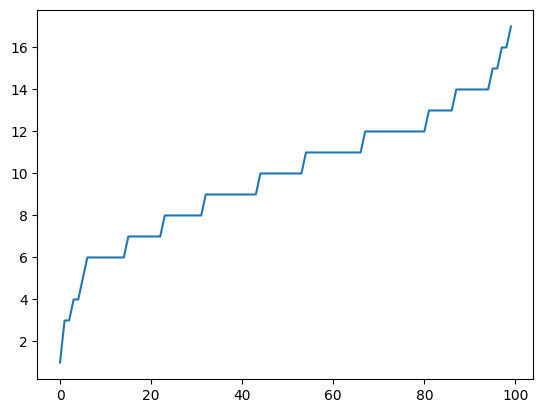

In [21]:
N = 10
k1,k2,k3 = N,N,1
support_mask = list(itertools.product(range(k1), range(k2), range(k3)))
trials = 1000
buckets_per_level = 10
level_gap = 5

hist, fail_count = ell_0_experiment(N, support_mask, trials, buckets_per_level, level_gap)
print(hist)
print(f"fails/trials: {fail_count}/{trials}")

plt.plot(sorted(hist))
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 2771.42it/s]


[64, 64, 69, 60, 45, 62, 66, 63]
507


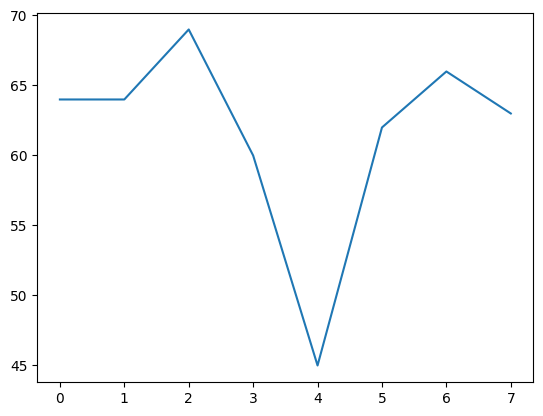

In [22]:
N = 10
k1,k2,k3 = 2,2,2
support_mask = list(itertools.product(range(k1), range(k2), range(k3)))
trials = 1000
buckets_per_level = 1
level_gap = 100

hist, fail_count = ell_0_experiment(N, support_mask, trials, buckets_per_level, level_gap)
print(hist)
print(fail_count)

plt.plot(hist)
plt.show()

100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


[57, 52, 63, 60, 80, 51, 56, 63, 62, 57, 62, 59, 57, 56, 56, 55]
54


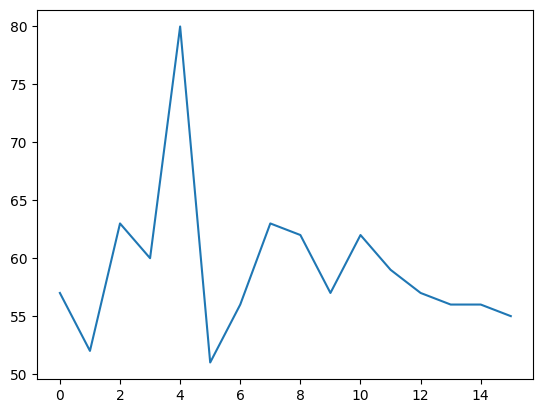

In [24]:
N = 40
k1,k2,k3 = 2,2,2
supp_size = k1*k2*k3

support_mask = list(itertools.product(range(k1), range(k2), range(k3)))

remaining_coords = [(i,j,k) for i,j,k in itertools.product(range(N), repeat=3) if (i,j,k) not in support_mask]

sampled_coords = random.sample(remaining_coords, supp_size)

support_mask = support_mask + sampled_coords

trials = 1000
buckets_per_level = 5
level_gap = 5

hist, fail_count = ell_0_experiment(N, support_mask, trials, buckets_per_level, level_gap)
print(hist)
print(fail_count)

plt.plot(hist)
plt.show()

In [ ]:
A = np.ones((50,50,50))
ell_0_sample(A, buckets_per_level=1, level_gap=5)

(1.0, 8e-06)

In [ ]:
N = 30
k1,k2,k3 = 2,2,2

A = np.zeros((N,N,N))
A[0:k1,0:k2,0:k3] = np.reshape(np.arange(k1*k2*k3), (k1,k2,k3))
ell_0_sample(A, buckets_per_level=10, level_gap=5)

(5.0, 0.023148148148148147)

0.0008

**Junk**

In [2]:
def B_sum_dense(X, T):
  #'''sum over (i,j,k) of X_{ijk} where i + j + k (mod N) in [0,T-1]'''

  cube_value_check(X)
  N = X.shape[0]

  if T > N:
    raise ValueError("T must be <= dimension of each mode")

  prod_tuples = itertools.product(range(N), repeat=3)
  return sum([X[i,j,k] for i,j,k in prod_tuples if 0 <= (i+j+k)%N <= T-1])

def C_sum_dense(X, T):
  '''
  vector whose index k entry is given by:
  sum over x_i y_j where i + j = k and 0 <= i-j <= T-1
  '''

  cube_value_check(X)
  N = X.shape[0]

  if T > N:
    raise ValueError("T must be <= dimension of each mode")


  return sum([X[i,j, (i+j) % N] for i,j in itertools.product(range(N), range(N))
      if 0 <= (i-j)%N <= T-1])